**배깅, 부스팅, 스태킹 등 여러 앙상블 기법를 구현하고 분석한다.**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

# 깔끔한 그래프 출력을 위해
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print(f"그림 저장: {fig_id}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 투표기반 분류기

In [2]:
import numpy as np

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

**<큰 수의 법칙>**

그림 저장: law_of_large_numbers_plot


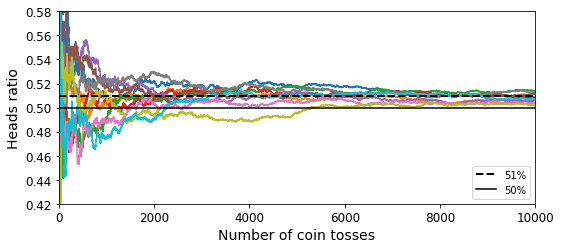

In [3]:
plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

moons 데이터셋을 사용해 본다:

In [4]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression(n_jobs=-1)
rnd_clf = RandomForestClassifier(n_jobs=-1)
svm_clf = SVC()
voting_clf = VotingClassifier(estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)], n_jobs=-1)

In [6]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(n_jobs=-1)),
                             ('rf', RandomForestClassifier(n_jobs=-1)),
                             ('svc', SVC())],
                 n_jobs=-1)

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.872
RandomForestClassifier 0.928
SVC 0.928
VotingClassifier 0.928


간접 투표:

In [8]:
log_clf = LogisticRegression(n_jobs=-1)
rnd_clf = RandomForestClassifier(n_jobs=-1)
svm_clf = SVC(probability=True)
voting_clf = VotingClassifier(estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)], voting="soft", n_jobs=-1)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(n_jobs=-1)),
                             ('rf', RandomForestClassifier(n_jobs=-1)),
                             ('svc', SVC(probability=True))],
                 n_jobs=-1, voting='soft')

In [9]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.872
RandomForestClassifier 0.928
SVC 0.928
VotingClassifier 0.936


# 배깅과 페이스팅

## 사이킷런의 배깅과 페이스팅

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [11]:
print(accuracy_score(y_test, y_pred))

0.936


In [12]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.904


**<단일 결정 트리(왼쪽)와 500개 트리로 만든 배깅 앙상블(오른쪽) 비교>**

In [13]:
from matplotlib.colors import ListedColormap


def plot_decision_boundary(clf, X, y, axes=None, alpha=0.5, contour=True):
    if axes is None:
        axes = [-1.5, 2.45, -1, 1.5]
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#7d7d58", "#4c4c7f", "#507d50"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

그림 저장: decision_tree_without_and_with_bagging_plot


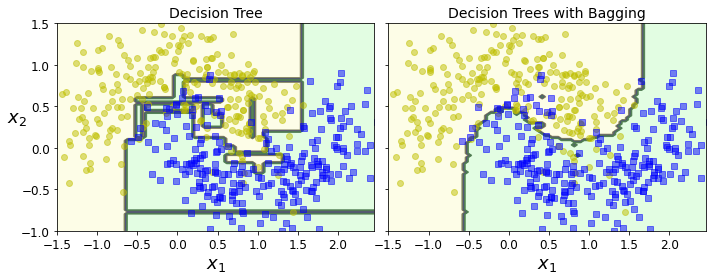

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel('')
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## OOB 평가

In [15]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, oob_score=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.872

In [16]:
bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [0.98469388, 0.01530612],
       [0.65934066, 0.34065934],
       [0.27979275, 0.72020725],
       [0.08474576, 0.91525424],
       [0.99497487, 0.00502513],
       [0.        , 1.        ],
       [0.56284153, 0.43715847],
       [0.87222222, 0.12777778],
       [0.32      , 0.68      ],
       [0.09473684, 0.90526316],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.05806452, 0.94193548],
       [0.99453552, 0.00546448],
       [0.54773869, 0.45226131],
       [0.98235294, 0.01764706],
       [1.        , 0.        ],
       [0.8960396 , 0.1039604 ],
       [0.95530726, 0.04469274],
       [0.03141361, 0.96858639],
       [0.98734177, 0.01265823],
       [0.00568182, 0.99431818],
       [0.        , 1.        ],
       [0.10555556, 0.89444444],
       [0.25842697, 0.74157303],
       [0.99462366, 0.00537634],
       [0.01005025, 0.98994975],
       [0.47486034, 0.52513966],
       [0.56020942, 0.43979058],
       [0.

In [17]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.928

# 랜덤 포레스트

In [18]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

랜덤 포레스트는 결정 트리의 배깅과 비슷하다:

In [19]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16), n_estimators=500, n_jobs=-1)

In [20]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [21]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # 거의 예측이 동일하다.

1.0

## 특성 중요도

In [22]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10751426284923647
sepal width (cm) 0.024139822323086667
petal length (cm) 0.4393291094776877
petal width (cm) 0.42901680534998915


In [23]:
rnd_clf.feature_importances_

array([0.10751426, 0.02413982, 0.43932911, 0.42901681])

다음 그림은 15개 결정 트리의 결정 경계를 중첩한 것이다. 여기서 볼 수 있듯이 개별 결정 트리는 불완전하지만 앙상블되면 매우 좋은 결정 경계를 만든다:

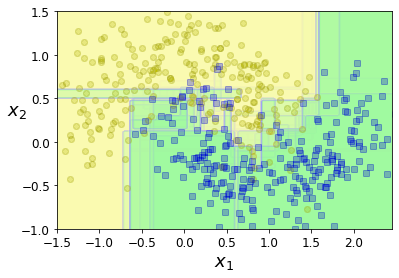

In [24]:
plt.figure(figsize=(6, 4))
for _ in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)
plt.show()

**<(랜덤 포레스트 분류기에서 얻은) MNIST 픽셀 중요도>**

In [25]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.target = mnist.target.astype(np.uint8)

In [26]:
rnd_clf = RandomForestClassifier(n_jobs=-1)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(n_jobs=-1)

In [27]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

그림 저장: mnist_feature_importance_plot


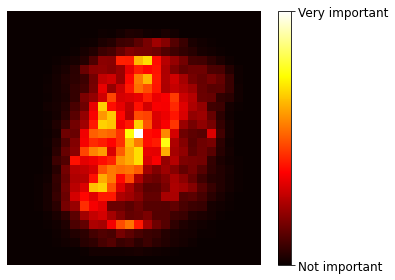

In [28]:
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(["Not important", "Very important"])
save_fig("mnist_feature_importance_plot")
plt.show()

# 부스팅

## 에이다부스트

In [29]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

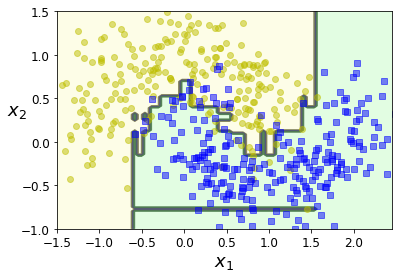

In [30]:
plot_decision_boundary(ada_clf, X, y)

**<연속된 예측기의 결정 경계>**

그림 저장: boosting_plot


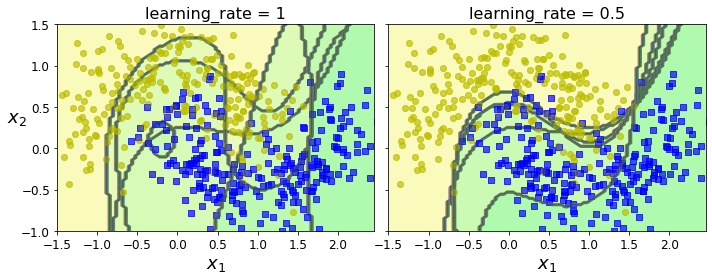

In [31]:
m = len(X_train)
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for _ in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum()
        alpha = learning_rate * np.log((1 - r) / r)
        sample_weights[y_pred != y_train] *= np.exp(alpha)
        sample_weights /= sample_weights.sum()  # 정규화 단계
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title(f"learning_rate = {learning_rate}", fontsize=16)
    if subplot:
        plt.ylabel('')
save_fig("boosting_plot")
plt.show()

# 그레이디언트 부스팅

간단한 이차식 형태의 데이터셋을 만들어 본다:

In [32]:
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

이제 이 데이터셋에 결정 트리 회귀 모델을 훈련시킨다:

In [33]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [34]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [35]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [36]:
X_new = np.array([[0.8]])

In [37]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [38]:
y_pred

array([0.66961186])

In [39]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

그림 저장: gradient_boosting_plot


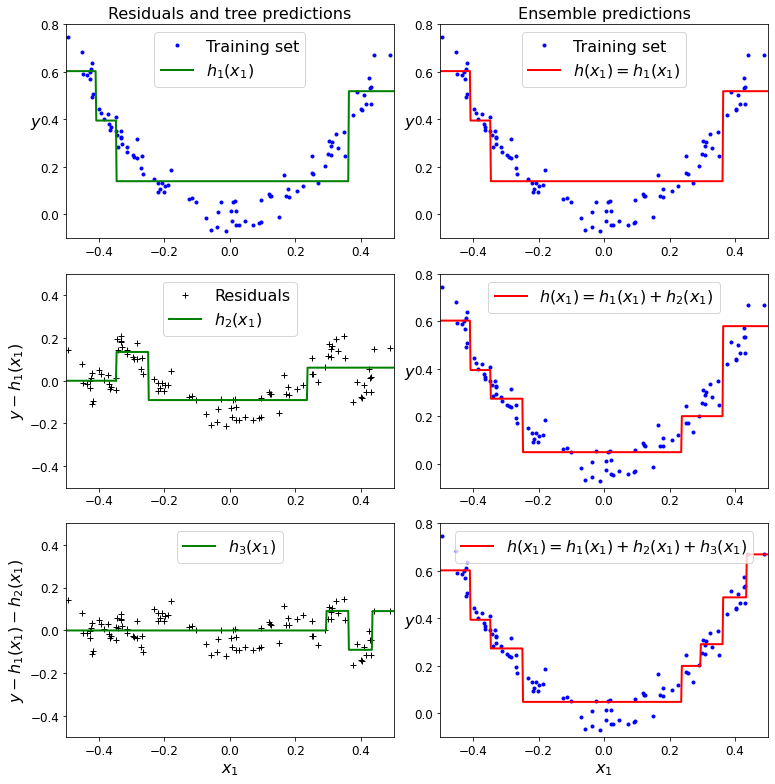

In [40]:
plt.figure(figsize=(11, 11))
plt.subplot(321)
plot_predictions(
    [tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set"
)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)
plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)
plt.subplot(323)
plot_predictions(
    [tree_reg2],
    X,
    y2,
    axes=[-0.5, 0.5, -0.5, 0.5],
    label="$h_2(x_1)$",
    style="g-",
    data_style="k+",
    data_label="Residuals"
)
plt.ylabel("$y - h_1(x_1)$", fontsize=16)
plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)
plt.subplot(326)
plot_predictions(
    [tree_reg1, tree_reg2, tree_reg3],
    X,
    y,
    axes=[-0.5, 0.5, -0.1, 0.8],
    label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$"
)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)
save_fig("gradient_boosting_plot")
plt.show()

이제 그레이디언트 부스팅 회귀 모델을 사용해 본다:

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

**<예측기가 부족한 경우(왼쪽)과 너무 많은 경우(오른쪽)의 GBRT 앙상블>**

In [42]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200)

그림 저장: gbrt_learning_rate_plot


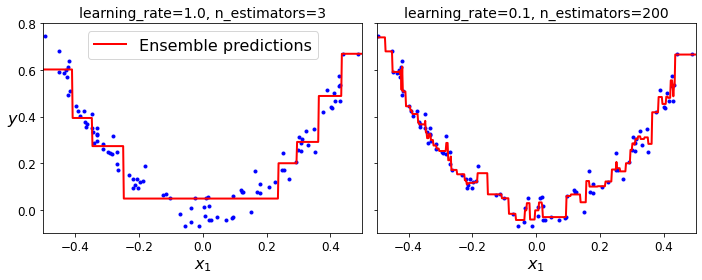

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, n_estimators={gbrt.n_estimators}", fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title(f"learning_rate={gbrt_slow.learning_rate}, n_estimators={gbrt_slow.n_estimators}", fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
save_fig("gbrt_learning_rate_plot")
plt.show()

**조기 종료를 사용한 그래디언트 부스팅**

In [44]:
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=58)

**<조기 종료를 사용하여 트리 수 튜닝>**

In [45]:
min_error = np.min(errors)

그림 저장: early_stopping_gbrt_plot


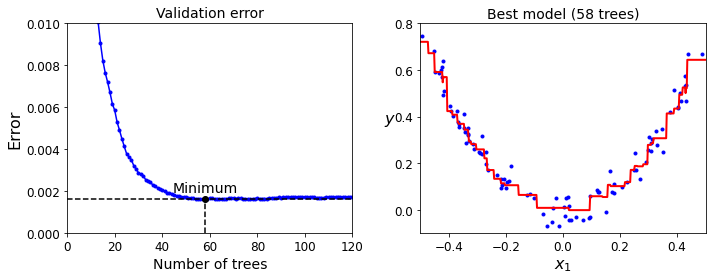

In [46]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error * 1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)
plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title(f"Best model ({bst_n_estimators} trees)", fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)
save_fig("early_stopping_gbrt_plot")
plt.show()

어느 정도 유예를 갖는 조기 종료(5 에포크 동안 향상되지 않을 때만 훈련 중지):

In [47]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

In [48]:
print(gbrt.n_estimators)

63


In [49]:
print(f"Minimum validation MSE: {min_val_error}")

Minimum validation MSE: 0.00162820540887637


**XGBoost 사용하기**

In [50]:
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리 설치되지 않았습니다.")
    xgboost = None

In [51]:
if xgboost is not None:
    xgb_reg = xgboost.XGBRegressor(n_jobs=-1)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print(f"Validation MSE: {val_error}")

Validation MSE: 0.002386507055367782


In [52]:
if xgboost is not None:
    xgb_reg = xgboost.XGBRegressor(early_stopping_rounds=2, n_jobs=-1)
    xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print(f"Validation MSE: {val_error}")

[0]	validation_0-rmse:0.24175
[1]	validation_0-rmse:0.17947
[2]	validation_0-rmse:0.13626
[3]	validation_0-rmse:0.10454
[4]	validation_0-rmse:0.08147
[5]	validation_0-rmse:0.06566
[6]	validation_0-rmse:0.05588
[7]	validation_0-rmse:0.05056
[8]	validation_0-rmse:0.04751
[9]	validation_0-rmse:0.04582
[10]	validation_0-rmse:0.04537
[11]	validation_0-rmse:0.04580
[12]	validation_0-rmse:0.04570
Validation MSE: 0.0020585911389358618


In [53]:
%timeit xgboost.XGBRegressor(n_jobs=-1).fit(X_train, y_train) if xgboost is not None else None

29.1 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [54]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

19.2 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# 연습

## 1. 투표 기반 분류기

_MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눈다(훈련에 20,000개 샘플, 검증에 20,000개 샘플, 테스트에 20,000개 샘플)._

MNIST 데이터셋은 앞에서 로드했다.

In [55]:
X_train_val, X_test, y_train_val, y_test = train_test_split(mnist.data, mnist.target, test_size=20000)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=20000)

_그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 같은 여러 종류의 분류기를 훈련시킨다._

In [56]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

random_forest_clf = RandomForestClassifier(n_jobs=-1)
extra_trees_clf = ExtraTreesClassifier(n_jobs=-1)
svm_clf = LinearSVC(max_iter=100, tol=20)
mlp_clf = MLPClassifier()

In [57]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print(f"Training the {estimator}")
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(n_jobs=-1)
Training the ExtraTreesClassifier(n_jobs=-1)
Training the LinearSVC(max_iter=100, tol=20)
Training the MLPClassifier()


In [58]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.962, 0.9655, 0.86865, 0.9554]

선형 SVM이 다른 분류기보다 성능이 많이 떨어진다. 그러나 투표 기반 분류기의 성능을 향상시킬 수 있으므로 그대로 둔다.

_그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 분류기를 사용하는 앙상블로 연결해 본다._

In [59]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf)
]

In [60]:
voting_clf = VotingClassifier(named_estimators, n_jobs=-1)

In [61]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(n_jobs=-1)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(n_jobs=-1)),
                             ('svm_clf', LinearSVC(max_iter=100, tol=20)),
                             ('mlp_clf', MLPClassifier())],
                 n_jobs=-1)

In [62]:
voting_clf.score(X_val, y_val)

0.9649

In [63]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9603, 0.9663, 0.84315, 0.9568]

SVM 모델을 제거해서 성능이 향상되는지 확인해 본다. 다음과 같이 `set_params()`를 사용하여 `None`으로 지정하면 특정 예측기를 제외시킬 수 있다:

In [64]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(n_jobs=-1)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(n_jobs=-1)),
                             ('svm_clf', None), ('mlp_clf', MLPClassifier())],
                 n_jobs=-1)

예측기 목록이 업데이트되었다:

In [65]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(n_jobs=-1)),
 ('extra_trees_clf', ExtraTreesClassifier(n_jobs=-1)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier())]

하지만 훈련된 예측기 목록은 업데이트되지 않는다:

In [66]:
voting_clf.estimators_

[RandomForestClassifier(n_jobs=-1),
 ExtraTreesClassifier(n_jobs=-1),
 LinearSVC(max_iter=100, tol=20),
 MLPClassifier()]

`VotingClassifier`를 다시 훈련시키거나 그냥 훈련된 예측기 목록에서 SVM 모델을 제거할 수 있다:

In [67]:
del voting_clf.estimators_[2]

`VotingClassifier`를 다시 평가해 본다:

In [68]:
voting_clf.score(X_val, y_val)

0.9677

조금 나아졌다! SVM 모델이 성능을 저하시켰다. 이제 간접 투표 분류기를 사용해 보자. 분류기를 다시 훈련시킬 필요는 없고 `voting`을 `"soft"`로 지정한다:

In [69]:
voting_clf.voting = "soft"

In [70]:
voting_clf.score(X_val, y_val)

0.9618

이 경우는 직접 투표 방식이 낫다.

_앙상블을 얻고 나면 테스트 세트로 확인해 본다. 개개의 분류기와 비교해서 성능이 얼마나 향상될까?_

In [71]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9699

In [72]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.96385, 0.96675, 0.9608]

여기서는 투표 기반 분류기가 최선의 모델의 오차율을 아주 조금만 감소시킨다.

## 2. 스태킹 앙상블

_이전 연습의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어 본다. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터고 타깃은 이미지의 클래스이다. 새로운 훈련 세트에 분류기 하나를 훈련시켜 보자._

In [73]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)
for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [74]:
X_val_predictions

array([[2., 2., 2., 2.],
       [5., 5., 3., 5.],
       [1., 1., 1., 1.],
       ...,
       [9., 9., 9., 9.],
       [6., 6., 6., 6.],
       [1., 1., 1., 1.]], dtype=float32)

In [75]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, n_jobs=-1)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, n_jobs=-1, oob_score=True)

In [76]:
rnd_forest_blender.oob_score_

0.96505

이 블렌더를 세밀하게 튜닝하거나 다른 종류의 블렌더(예를 들어, `MLPClassifier`)를 시도해 볼 수 있다. 그런 다음 늘 하던대로 교차 검증을 사용해 가장 좋은 것을 선택한다.

_방금 블렌더를 훈련시켰다. 그리고 이 분류기를 모아서 스태킹 앙상블을 구성했다. 이제 테스트 세트에 앙상블을 평가해 본다. 테스트 세트의 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그 예측을 주입한다. 앞서 만든 투표 분류기와 비교하면 어떨까?_

In [77]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)
for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [78]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [79]:
accuracy_score(y_test, y_pred)

0.9687

이 스태킹 앙상블은 앞서 만든 투표 기반 분류기만큼 성능을 내지는 못한다. 최선의 개별 분류기만큼 뛰어나지는 않다.